# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [1]:
# Load the libraries as required.
import os
import sys
import json
import requests
import pandas as pd

In [2]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# 1. Define Features (X)
# We drop the target column 'area'. axis=1 means we are dropping a column, axis=0 would mean dropping a row.
X = fires_dt.drop('area', axis=1)

# 2. Define Target (y)
y = fires_dt['area']

# 3. Split the data into training and test sets, with 20% of the data as test set and random_state=42 for reproducibility because we are fans of The Hitchhiker's Guide to the Galaxy.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Display the shapes of the resulting datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (413, 12)
X_test shape: (104, 12)
y_train shape: (413,)
y_test shape: (104,)


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [5]:
# Define the column groups explicitly
categorical_columns = ['month', 'day']
numerical_columns = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. Define the transformers for numerical and categorical features
num_transformer_1 = Pipeline(steps=[
    ('scaler', StandardScaler())
])
# as per instruction, only one categorical transformer is defined with one-hot encoding.
categorical_transformer_1 = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# 2 Combine the transformers into a ColumnTransformer
preproc1 = ColumnTransformer(
    transformers=[
        ('num', num_transformer_1, numerical_columns),
        ('cat', categorical_transformer_1, categorical_columns)
    ]
)   

print("Preprocessing pipeline 1:")
print(preproc1)
print("Preproc1 defined successfully.")

Preprocessing pipeline 1:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])
Preproc1 defined successfully.


### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [7]:
from sklearn.preprocessing import PowerTransformer

# 1. Define the Advanced Numeric Transformer (Scale + Power Transform)
num_transformer_2 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('power', PowerTransformer(method='yeo-johnson')) # This is the "Non-linear transformation"
])

# 2. Reuse the categorical transformer from before (no need to redefine if it exists)
# categorical_transformer_1 is fine to reuse

# 3. Bundle into Preproc 2
preproc2 = ColumnTransformer(
    transformers=[
        ('num', num_transformer_2, numerical_columns),
        ('cat', categorical_transformer_1, categorical_columns)
    ])


print("Preprocessing pipeline 2:")
print(preproc2)
print("Preproc2 defined successfully.")

Preprocessing pipeline 2:
ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('power',
                                                  PowerTransformer())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['month', 'day'])])
Preproc2 defined successfully.


## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [8]:
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor # I originally used randomforest, but it was worse than Ridge, so I redid the test with XGBoost...below same result.
import xgboost as xgb
#baseline model is Ridge Regression.  I chose this over Linear Regression because I expect fire data will be noisy and Linear Regression would try to fit every point exactly, aka overfitting.


In [9]:

# Pipeline A = preproc1 + baseline
pipeline_a = Pipeline(steps=[
    ('preprocessor', preproc1),
    ('regressor', Ridge())
])  


In [11]:
# Pipeline B = preproc2 + baseline

pipeline_b = Pipeline(steps=[
    ('preprocessor', preproc2),
    ('regressor', Ridge())
])

In [13]:
xgb_model = xgb.XGBRegressor(objective ='reg:squarederror', random_state=42)
# Pipeline C = preproc1 + advanced model
pipeline_c = Pipeline(steps=[
    ('preprocessor', preproc1),
    ('regressor', xgb_model)
])

In [14]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline(steps=[
    ('preprocessor', preproc2),
    ('regressor', xgb_model)
])

    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [15]:
from sklearn.model_selection import GridSearchCV
#totalError= Bias2+Variance+Noise
#Ridge Hyperparams
#alpha: Larger values spcify stronger regulariztion....using powers of 10 for a wide range...
param_grid_ridge={
    'regressor__alpha':[.1,1.0,10,100,1000]  
}

#Random Forest Hyperparams
#n_estimators is the number of trees
#max_depth is the maximum depth of tress to avoid overfitting
param_grid_rf ={
    'regressor__n_estimators':[50,100,1000],
    'regressor__max_depth':[None,10,20,30,40]
}

# XGBoost Hyperparams- random forest was worse than Ridge, so I redid the test with XGBoost
param_grid_xgb = {
    'regressor__n_estimators': [50, 100],
    'regressor__learning_rate': [0.01, 0.1],
    'regressor__max_depth': [3, 6]
}
print("Hyperparameter grids defined successfully.")


# define the models
ridge_model = Ridge()
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# define the piplines

pipe_A = Pipeline(steps=[
    ('preprocessor', preproc1),
    ('regressor', ridge_model)
])

pipe_B = Pipeline(steps=[
    ('preprocessor', preproc2),
    ('regressor', ridge_model)
])

pipe_C = Pipeline(steps=[
    ('preprocessor', preproc1),
    ('regressor', xgb_model)
])

pipe_D = Pipeline(steps=[
    ('preprocessor', preproc2),
    ('regressor', xgb_model)
])
print("Pipelines defined successfully.")

Hyperparameter grids defined successfully.
Pipelines defined successfully.


In [16]:
# We pair the Pipeline with its specific Parameter Grid.  We experiment methotically with a controlled tournament.
experiments = [
    ("Pipeline A", pipe_A, param_grid_ridge),
    ("Pipeline B", pipe_B, param_grid_ridge),
    ("Pipeline C", pipe_C, param_grid_xgb),
    ("Pipeline D", pipe_D, param_grid_xgb)
]

In [17]:
results = {}
# Loop through each experiment, perform GridSearchCV, and store the results
for name, pipeline, param_grid in experiments:
    print(f"training {name}...")
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, n_jobs=1, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    results[name] = grid_search
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best CV MSE for {name}: {-grid_search.best_score_}")
    print(f" Best Param: {grid_search.best_params_}\n")

training Pipeline A...
Best parameters for Pipeline A: {'regressor__alpha': 1000}
Best CV MSE for Pipeline A: 2083.6363573688786
 Best Param: {'regressor__alpha': 1000}

training Pipeline B...
Best parameters for Pipeline B: {'regressor__alpha': 1000}
Best CV MSE for Pipeline B: 2085.2531535982152
 Best Param: {'regressor__alpha': 1000}

training Pipeline C...
Best parameters for Pipeline C: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
Best CV MSE for Pipeline C: 2252.5406580236345
 Best Param: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}

training Pipeline D...
Best parameters for Pipeline D: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
Best CV MSE for Pipeline D: 2252.5406580236345
 Best Param: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}



In [18]:
import pickle

#Winning Pipeline
best_pipeline_name = max(results, key=lambda name: results[name].best_score_)

#Extracting the score and model
best_score_neg_rmse = results[best_pipeline_name].best_score_
best_model = results[best_pipeline_name].best_estimator_


# The score is negative RMSE, we flip the sign to get positive RMSE
print(f"Tournament Winner: {best_pipeline_name}")
print(f"Best CV Score (RMSE): {-best_score_neg_rmse:.4f}")

#Save best model to a pickle file
best_model_file = 'best_forest_fire_model.pkl'
with open(best_model_file, 'wb') as f:
    pickle.dump(best_model, f)

print(f"Successfully saved the best model to: {best_model_file}")

Tournament Winner: Pipeline A
Best CV Score (RMSE): 2083.6364
Successfully saved the best model to: best_forest_fire_model.pkl


# Evaluate

+ Which model has the best performance?

# Export

+ Save the best performing model to a pickle file.

In [20]:
import shap 
# Create a SHAP explainer using the best model
winning_pipeline = results[best_pipeline_name].best_estimator_
# We need to extract the preprocessor and the regressor separately
preprocessor = winning_pipeline.named_steps['preprocessor']
regressor = winning_pipeline.named_steps['regressor']

# Preprocess the training data
X_train_processed = preprocessor.transform(X_train)

# Feature names for the SHAP summary plot
OneHotEncoder_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_columns)
numerical_names = numerical_columns
feature_names = list(numerical_names) + list(OneHotEncoder_names)

#Linear explainer for Ridge, TreeExplainer for XGBoost
if best_pipeline_name in ["Pipeline A", "Pipeline B"]:
    explainer = shap.LinearExplainer(regressor, X_train_processed, feature_names=feature_names)
else:
    explainer = shap.TreeExplainer(regressor, feature_names=feature_names)  
    shap_values = explainer.shap_values(X_train_processed)

print("SHAP explainer created successfully.")


/Users/seanbrennan/production-dsi/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP explainer created successfully.


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

Global Feature Importance Summary Plot:


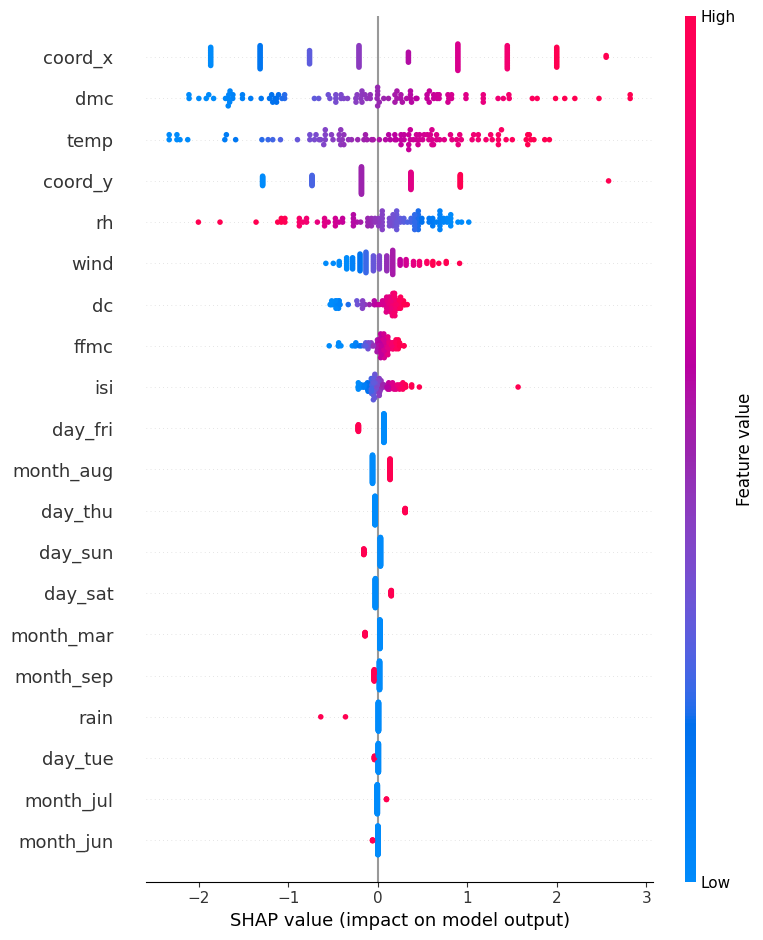

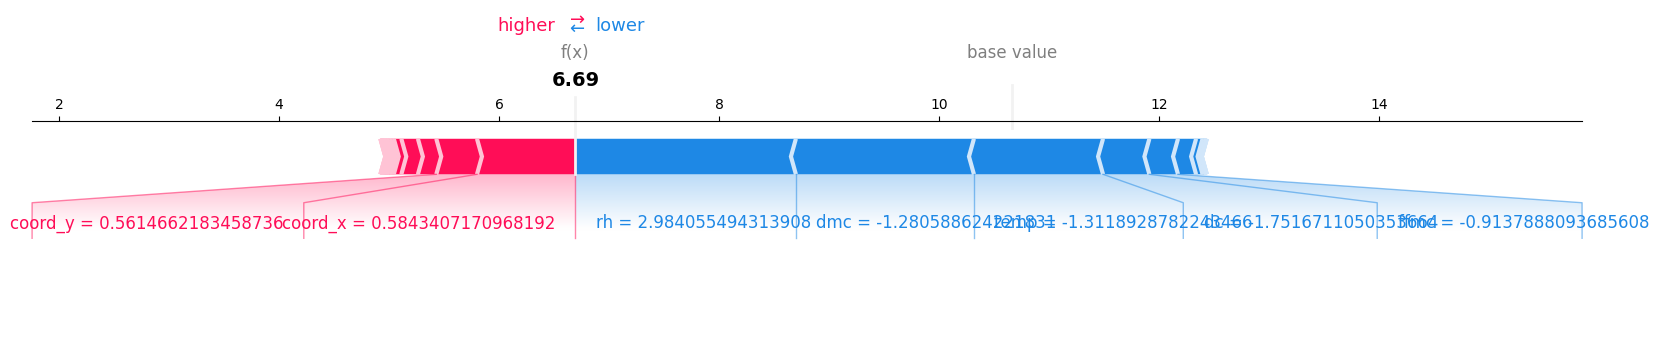

In [24]:
#Use waterfall and summary plots to create trust.
# Pul in Shap Values for test set
X_test_processed = preprocessor.transform(X_test)
shap_values_test = explainer.shap_values(X_test_processed)

#Across the full set, which features are most important:
print("Global Feature Importance Summary Plot:")
shap.summary_plot(shap_values_test, X_test_processed, feature_names=feature_names)

#Use matplotlib=true so it renders in Jupyter Notebook.
shap.force_plot(
    explainer.expected_value, 
    shap_values_test[0,:], 
    X_test_processed[0,:], 
    feature_names=feature_names, 
    matplotlib=True
)

More readable explanation for test observation#0 Value: 10.659


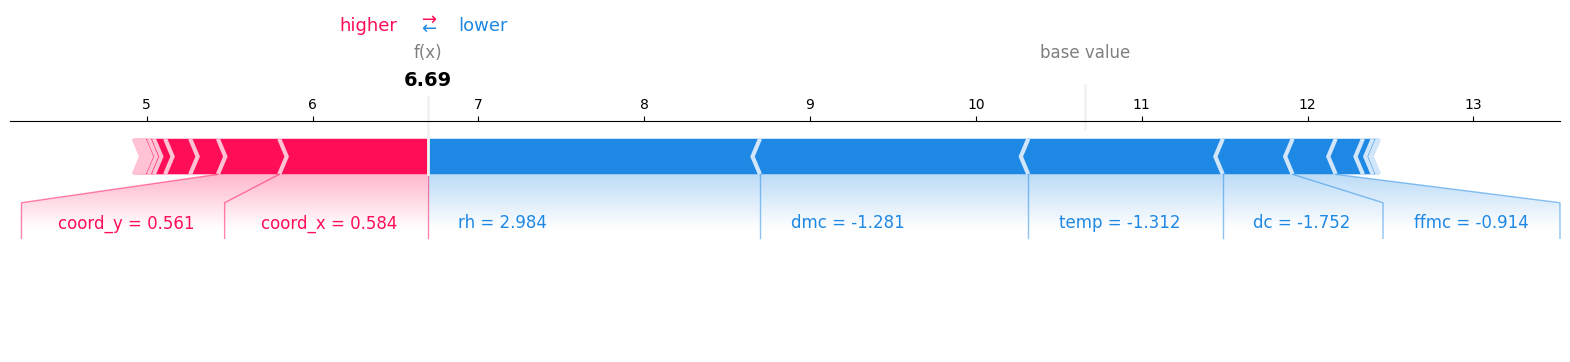

In [26]:
import numpy as np

rounded_base_value = np.round(explainer.expected_value, 3)
rounded_shap_values = np.round(shap_values_test[0,:], 3)
rounded_features = np.round(X_test_processed[0,:], 3)

print(f"More readable explanation for test observation#0 Value: {rounded_base_value}")
shap.force_plot(
    rounded_base_value,
    rounded_shap_values,
    rounded_features,
    feature_names=feature_names,
    matplotlib=True
)

The features that are most important are, in order of importance: coord_x, dmc, temp, coord_y, rh, wind, dec, ffmc isi
The least important features are rain and month and days.  
I would remove all the least important features and retrain to see if model performance improves.  If it is the same or better, (RMSE =2083 or less) then those features can be dropped to remove technical debt for a simpler model.
The model predited that this fire would burn 6.69 hectares, where the average is 10.8 hectares(estimate)...rh= 2.98 is the main pulling factor along with dmc at -1.28 and temp at -1.31 and dc -1.75.

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.